#### **Description of the features in the dataset**

- X1 Relative Compactness -> Ratio of the building’s volume to its surface area.

- X2 Surface Area -> Total external area of the building (walls + roof + floor).

- X3 Wall Area -> Total area of the building’s walls.

- X4 Roof Area -> Total area of the roof.

- X5 Overall Height -> Vertical height of the building.

- X6 Orientation -> Direction the building faces (e.g., north, south, east, west), often encoded as integers (1–4).

- X7 Glazing Area -> Fraction of the building façade that is glass (windows).

- X8 Glazing Area Distribution -> How windows are distributed around the building (e.g., uniform, south-only, north-south, etc.).

- **Y1 (Target Variable) Heating Load -> The amount of energy required to heat the building to a comfortable temperature.**

Goal: Predict this value accurately using the above features.

In [966]:
# importing needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### **EXPLORATORY DATA ANALYSIS**

In [967]:
data = pd.read_excel("Training_dataset.xlsx")
data.tail()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,Y1
693,694,0.76,661.5,416.5,122.5,7.0,3,0.4,4,40.40
694,695,0.76,661.5,416.5,122.5,7.0,4,0.4,4,40.60
695,696,0.76,661.5,416.5,122.5,7.0,5,0.4,4,40.11
696,697,0.74,686.0,245.0,220.5,3.5,2,0.4,4,14.37
697,698,0.74,686.0,245.0,220.5,3.5,3,0.4,4,14.48


In [968]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 698 entries, 0 to 697
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ID      698 non-null    int64  
 1   X1      698 non-null    float64
 2   X2      698 non-null    float64
 3   X3      698 non-null    float64
 4   X4      698 non-null    float64
 5   X5      698 non-null    float64
 6   X6      698 non-null    int64  
 7   X7      698 non-null    float64
 8   X8      698 non-null    int64  
 9   Y1      698 non-null    float64
dtypes: float64(7), int64(3)
memory usage: 54.7 KB


From the description of the data's info above, it seems there are no null entries throughout the entire training set.

In [969]:
data.describe()

,ID,X1,X2,X3,X4,X5,X6,X7,X8,Y1
count,698.00000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000,698.000000
mean,349.50000,0.767106,669.151862,318.710602,175.220630,5.305158,3.497135,0.217765,2.624642,22.319908
std,201.63953,0.105898,87.988814,43.743818,45.186276,1.750385,1.118832,0.128448,1.495884,10.127774
min,1.00000,0.620000,514.500000,245.000000,110.250000,3.500000,2.000000,0.000000,0.000000,6.010000
25%,175.25000,0.690000,588.000000,294.000000,122.500000,3.500000,2.250000,0.100000,1.000000,12.887500
50%,349.50000,0.760000,661.500000,318.500000,147.000000,7.000000,3.000000,0.250000,3.000000,19.600000
75%,523.75000,0.860000,735.000000,343.000000,220.500000,7.000000,4.000000,0.250000,4.000000,31.655000
max,698.00000,0.980000,808.500000,416.500000,220.500000,7.000000,5.000000,0.400000,5.000000,43.100000


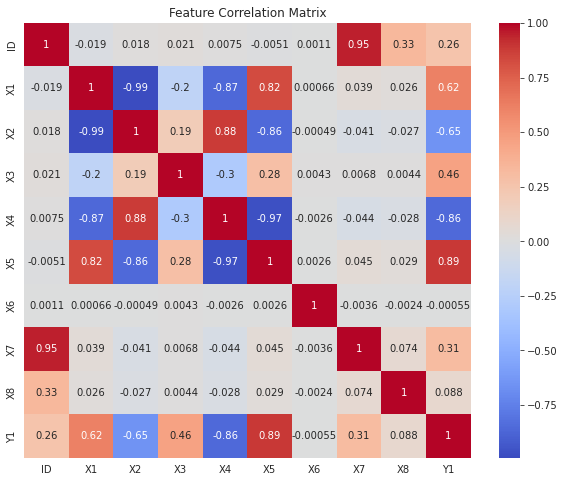

In [970]:
plt.figure(figsize=(10, 8))  # width=10, height=8 in inches
sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Matrix')
plt.show()

The correlation heatmap suggests multi-colinearity between some features e.g.

- ID and X7, X8
- X1 and X2, X4, X5
It's something to look out for in choosing the algorithm to be used since others perform poorly when the features are significantly correlated.

**Seeing the correlation heatmap above, let's see how each feature particularly relates to the target variable Y1.**

In [971]:
data.corr()['Y1'].sort_values(ascending=False)

Y1    1.000000
X5    0.887797
X1    0.616147
X3    0.458827
X7    0.308616
ID    0.256765
X8    0.087950
X6   -0.000547
X2   -0.654049
X4   -0.858887
Name: Y1, dtype: float64

Model-based insight on feature importance (not finally the model I will use to train, just using it to get an idea of the importance of each feature in predicting Y1):

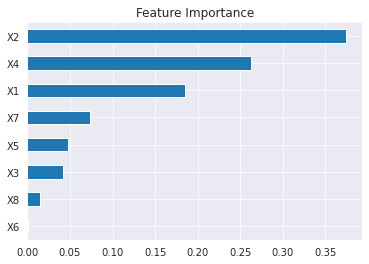

In [972]:
from sklearn.ensemble import RandomForestRegressor

X = data.drop(columns=['ID', 'Y1'])
y = data['Y1']

model = RandomForestRegressor().fit(X, y)
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values().plot(kind='barh', title='Feature Importance')
plt.show()

From the result above, we see that X6 is the least important feature, let's look at how it's distributed.

Orientation seems to be coded, and the numbers represent the cardinalities North, West, South, East. To explore their distribution against Y1:

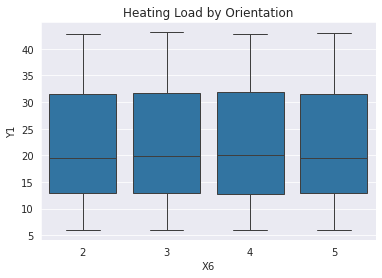

In [973]:
sns.boxplot(x='X6', y='Y1', data=data)
plt.title('Heating Load by Orientation')
plt.show()

The very low importance of the feature X6 is well depicted in the boxplots distributions of the Orientation vs Y1.

Their boxlplots are nearly identical, suggesting no variation between them in relation to the target variable.

#### **TRAINING**

Now that I've got a clearly understanding of what I'm dealing with, I'll start training.

The final test data has no Y1 provided since they should be provided from my model.

To evaluate model performance though, I will split the available training set into train and test to see how it will perform.

After doing this, I will then train the best model with the complete training set to improve its generalization.

The final best model is the one I will use to predict values for the target in the test set.

In [974]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X = data.drop(columns=['ID', 'Y1'])
y = data['Y1']
print(y.head())

0    15.55
1    15.55
2    15.55
3    15.55
4    20.84
Name: Y1, dtype: float64


In [975]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [976]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

In [977]:
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from joblib import dump

In [978]:
# Candidate models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Lasso Regression": Lasso(alpha=0.01),
    "Decision Tree": DecisionTreeRegressor(max_depth=6, random_state=42),
    "Random Forest": RandomForestRegressor(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=1000, random_state=42, max_depth=4),
    "Support Vector Regressor": SVR(kernel='rbf', C=10, gamma='scale')
}

#### **EVALUATION**

In [979]:
# Train and evaluate
results = []
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_val_scaled)
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    results.append({'Model': name, 'RMSE': rmse, 'Model_Object': model})
    print(f"{name}: RMSE = {rmse:.4f}")

Linear Regression: RMSE = 2.8989
Ridge Regression: RMSE = 2.9052
Lasso Regression: RMSE = 2.9120
Decision Tree: RMSE = 0.5963


/home/zviko/.local/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.202e+00, tolerance: 5.692e+00
  model = cd_fast.enet_coordinate_descent(


Random Forest: RMSE = 0.5249
Gradient Boosting: RMSE = 0.4119
Support Vector Regressor: RMSE = 2.6430


In [980]:
results_df = pd.DataFrame(results).sort_values("RMSE").reset_index(drop=True)
# results_df.sort_values(by='RMSE', inplace=True, ignore_index=True)
results_df

,Model,RMSE,Model_Object
0,Gradient Boosting,0.411918,([DecisionTreeRegressor(criterion='friedman_ms...
1,Random Forest,0.524915,"(DecisionTreeRegressor(max_features=1.0, rando..."
2,Decision Tree,0.596275,"DecisionTreeRegressor(max_depth=6, random_stat..."
3,Support Vector Regressor,2.642979,SVR(C=10)
4,Linear Regression,2.898947,LinearRegression()
5,Ridge Regression,2.905151,Ridge()
6,Lasso Regression,2.911984,Lasso(alpha=0.01)


It seems like linear models are underperforming as compared to non-linear ones. This might mean that linear regression could perform better is the degree is changed:

In [981]:
from sklearn.preprocessing import PolynomialFeatures

In [982]:
# trying different polynomial degrees
for deg in range(1, 7, 1):
    poly = PolynomialFeatures(degree=deg, include_bias=False)
    X_train_poly = poly.fit_transform(X_train_scaled)
    X_val_poly = poly.transform(X_val_scaled)

    # Fit Linear Regression on polynomial-transformed data
    poly_lr = LinearRegression()
    poly_lr.fit(X_train_poly, y_train)

    # Predict on validation data
    y_pred_poly = poly_lr.predict(X_val_poly)

    # Evaluate RMSE
    rmse_poly = np.sqrt(mean_squared_error(y_val, y_pred_poly))
    print(f"Linear Regression (Polynomial degree={deg}) RMSE: {rmse_poly:.4f}")

Linear Regression (Polynomial degree=1) RMSE: 2.8989
Linear Regression (Polynomial degree=2) RMSE: 0.7634
Linear Regression (Polynomial degree=3) RMSE: 0.5329
Linear Regression (Polynomial degree=4) RMSE: 0.4681
Linear Regression (Polynomial degree=5) RMSE: 0.5623
Linear Regression (Polynomial degree=6) RMSE: 0.9098


It makes sense why the linear regression of degree one was underperforming. 

Increasing the degree would improve its accuracy up to a certain point then it starts decreasing again. 

But anyway, GradientBoosting is still performing the best so I'll choose it as my final model

In [983]:
best_model = results_df.iloc[0]['Model']
dump(models[best_model], 'best_model.joblib')


['best_model.joblib']

In [984]:
final_model = GradientBoostingRegressor(
    n_estimators=500,
    random_state=42,
    max_depth=6,
    learning_rate=0.015
)

In [985]:
X = data.drop(columns=['ID', 'Y1'])
y = data['Y1']

In [986]:
X_scale = scaler.transform(X)

In [987]:
final_model.fit(X_scale, y)
dump(final_model, 'final_model.joblib')

['final_model.joblib']

In [988]:
import joblib
model = joblib.load("final_model.joblib")
print("Model loaded successfully!")

# 2️⃣ Load your test dataset
test_data = pd.read_excel("test_dataset.xlsx")

# 3️⃣ Keep the IDs for submission
test_ids = test_data["ID"]

# 4️⃣ Drop the ID column for prediction input
test_X = test_data.drop(columns=["ID"])

# 5️⃣ Use the model to make predictions
preds = model.predict(scaler.transform(test_X))

# 6️⃣ Round predictions to two decimal places (as required)
preds = [round(float(p), 2) for p in preds]

# 7️⃣ Create a DataFrame for submission
submission = pd.DataFrame({
    "ID": test_ids,
    "Heating_Load": preds
})

# 8️⃣ Save as CSV
submission.to_csv("student_submission.csv", index=False)
print("✅ Predictions saved to 'student_submission.csv'")

# 9️⃣ (Optional) Display the first few predictions
print(submission.head())

Model loaded successfully!
✅ Predictions saved to 'student_submission.csv'
    ID  Heating_Load
0  700         14.22
1  701         14.23
2  702         14.33
3  703         14.37
4  704         14.15
